In [13]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter


Primero se definen los parámetros y las funciones a utilizar
- $m$, $m_d$: Masas
- $\xi$, $\xi_d$: Coeficiente de amortiguamiento
- $k$, $k_d: Constante de elasticidad
- $l_1$, $l_2$: Longitudes naturales de los resortes
- $\Omega$: Frecuencia de oscilación del terremoto
- $F_0$: Magnitud del terremoto
- $u$, $u_d$: Posiciones relativas de las masas

In [14]:
xi, xi_d, k, k_d, l1, l2, bw, f0, m, m_d, t = smp.symbols(r'\xi \xi_d k k_d l_1 l_2 \Omega F_0 m m_d t')

In [15]:
u, ud, x1, x2, f = smp.symbols(r'u u_d x_1 x_2 f', cls=smp.Function)

In [16]:
# U
u = u(t)
u_dif = smp.diff(u, t)
u_ddif = smp.diff(u_dif, t)


#U_d
ud = ud(t)
ud_dif = smp.diff(ud, t)
ud_ddif = smp.diff(ud_dif, t)

#Positions

x1 = x1(u)
x2 = x2(u, ud)
x1 = u
x2 = u + ud

#Force
f = f(t)
f = f0*smp.sin(bw*t)

In [17]:
mbar = m_d/m
w = smp.sqrt(k/m)
w_d = smp.sqrt(k_d/m_d)
c = 2*xi*w*m
c_d = 2*xi_d*w_d*m_d

Se introducen las ecuaciones de movimiento

In [18]:
eq_struct = smp.Eq(m*u_ddif,  -k*(u - l1) - c*u_dif + k_d*(ud - l2) + c_d*ud_dif + f)
eq_tunned = smp.Eq(m_d*(u_ddif + ud_ddif),  - k_d*(ud - l2) - c_d*ud_dif)

In [19]:
eq_struct

Eq(m*Derivative(u(t), (t, 2)), F_0*sin(\Omega*t) - 2*\xi*m*sqrt(k/m)*Derivative(u(t), t) + 2*\xi_d*m_d*sqrt(k_d/m_d)*Derivative(u_d(t), t) - k*(-l_1 + u(t)) + k_d*(-l_2 + u_d(t)))

In [20]:
eq_tunned

Eq(m_d*(Derivative(u(t), (t, 2)) + Derivative(u_d(t), (t, 2))), -2*\xi_d*m_d*sqrt(k_d/m_d)*Derivative(u_d(t), t) - k_d*(-l_2 + u_d(t)))

Se despejan las segundas derivadas

In [21]:
sols = smp.solve([eq_struct, eq_tunned], (u_ddif, ud_ddif), simplify = True, rational= False)

In [22]:
sols[ud_ddif]

(k_d*m*(l_2 - u_d(t)) + 2*m*m_d*(\xi*sqrt(k/m)*Derivative(u(t), t) - \xi_d*sqrt(k_d/m_d)*Derivative(u_d(t), t)) + m_d*(-F_0*sin(\Omega*t) - 2*\xi_d*m_d*sqrt(k_d/m_d)*Derivative(u_d(t), t) - k*l_1 + k*u(t) + k_d*l_2 - k_d*u_d(t)))/(m*m_d)

In [23]:
sols[u_ddif]

(F_0*sin(\Omega*t) - 2*\xi*m*sqrt(k/m)*Derivative(u(t), t) + 2*\xi_d*m_d*sqrt(k_d/m_d)*Derivative(u_d(t), t) + k*l_1 - k*u(t) - k_d*l_2 + k_d*u_d(t))/m

Se convierten a expresiones numéricas con el fin de poder utilizar métodos númericos para resolverlas. Dividiendo el sistema de dos ecuaciones de segundo orden en cuatro ecuaciones de primer orden, de modo que:
- $du/dt = v$
- $d^2u/dt^2 = dv/dt = \dots$

In [24]:
dudt_f = smp.lambdify(u_dif, u_dif, modules=['numpy']) 
dvdt_f = smp.lambdify((xi, xi_d, k, k_d, l1, l2, bw, f0, m, m_d, u, u_dif, ud, ud_dif, t), sols[u_ddif], modules=['numpy']) 

du_ddt_f = smp.lambdify(ud_dif, ud_dif, modules=['numpy'])
dv_ddt_f = smp.lambdify((xi, xi_d, k, k_d, l1, l2, bw, f0, m, m_d, u, u_dif, ud, ud_dif, t), sols[ud_ddif], modules=['numpy'])

Se define el sistema a resolver de la forma $S = S(u, v, u_d, v_d)$ 

In [25]:
def dSdt(S, t):
    u, v, ud, vd = S
    return [
    dudt_f(v),
    dvdt_f(xi, xi_d, k, k_d, l1, l2, bw, f0, m, m_d, u, v, ud, vd, t),
    du_ddt_f(vd),
    dv_ddt_f(xi, xi_d, k, k_d, l1, l2, bw, f0, m, m_d, u, v, ud, vd, t)
    ]

Se introducen los valores numéricos de los parámetros y las condiciones iniciales del sistema

In [26]:
t = np.linspace(0, 40, 1000)

#Parameters of the structure
m = 8.0
w = 2.0
k = np.power(w, 2)*m
l1 = 10.0
xi = 0.1

#Parameters of tunned mass
m_d= 4.0
w_d = 2.0
k_d = np.power(w_d, 2)*m_d
l2 = 10.0
xi_d = 0.2

#Force parameters
f0 = 20.0
bw = 2.0

#Intial u, v, u_d and v_d
y0=[10.0, 0, 10.0 ,0]
ans = odeint(dSdt, y0, t=t)

In [27]:
k, k_d

(32.0, 16.0)

Se obtienen las soluciones numéricas para $u$ y $u_d$ y a partir de éstas calculamos las posiciones $x_1$ y $x_2$ de las masas

In [28]:
u = ans.T[0]
ud = ans.T[2]

In [29]:
def get_x1x2(u, ud):
    return(u, u+ud)

x1, x2 = get_x1x2(u, ud)

In [30]:
#Amplitudes
A1 = x1-y0[0]
A2 = x2-y0[0]-y0[2]

Obtenemos la gráfica de la amplitud de osiclación de la estructura en función del tiempo

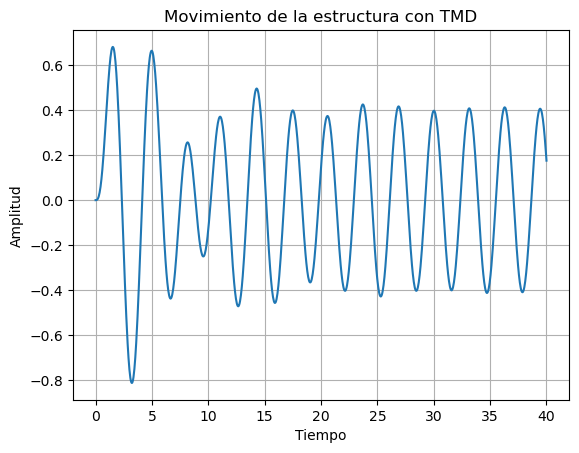

In [32]:
plt.title(f"Movimiento de la estructura con TMD")
plt.xlabel(f"Tiempo")
plt.ylabel(f"Amplitud")
plt.grid()
plt.plot(t, A1)

Adicionalmente podemos analizar la amplitud en función del tiempo de la masa sintonizada

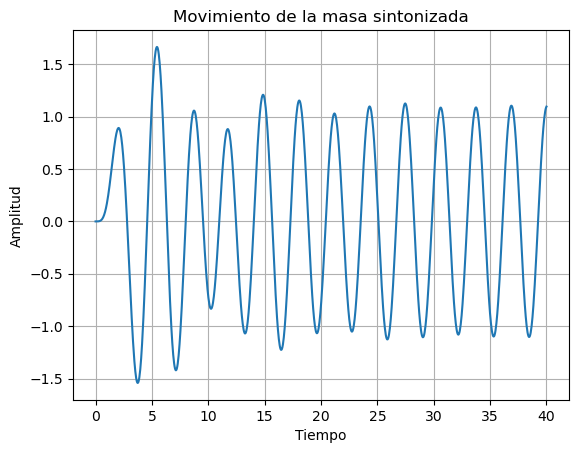

In [33]:
plt.title(f"Movimiento de la masa sintonizada")
plt.xlabel(f"Tiempo")
plt.ylabel(f"Amplitud")
plt.grid()
plt.plot(t, A2)

Finalmente podemos realizar una simulación del sistema en formato GIF

In [23]:
#Animation (GIF)
def animate(i):
    ax.clear()
    ax.grid()

    # Define the side length for the square boxes
    box_size = 1.5

    # Draw mass 1
    rect1 = plt.Rectangle((x1[i] - box_size / 2, 0), box_size, box_size, edgecolor='black', facecolor='red')
    ax.add_patch(rect1)

    # Draw spring 1
    spring1 = plt.Line2D([0, x1[i] - box_size / 2], [box_size / 2, box_size / 2], color='grey', linestyle='-', linewidth=2)
    ax.add_line(spring1)

    # Draw mass 2
    rect2 = plt.Rectangle((x2[i] - box_size / 2, 0), box_size, box_size, edgecolor='blue', facecolor='blue')
    ax.add_patch(rect2)

    # Draw spring 2
    spring2 = plt.Line2D([x1[i] + box_size / 2, x2[i] - box_size / 2], [box_size / 2, box_size / 2], color='grey', linestyle='-', linewidth=2)
    ax.add_line(spring2)

    # Draw the ground
    ax.add_line(plt.Line2D([0, 22], [0, 0], color='black', linestyle='-', linewidth=2))

    ax.set_ylim(-0.5, 2)
    ax.set_xlim(0, 25)
    ax.set_title(f'Time: {t[i]:.2f}s')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('TMD.gif', writer='pillow', fps=25)